<a href="https://colab.research.google.com/github/byewokko/guessing-game/blob/master/Guessing_game_REINFORCE_2.4.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Run once to get functions and datasets from my guessing-game repo
!wget https://raw.githubusercontent.com/byewokko/guessing-game/master/game/game.py
!wget https://raw.githubusercontent.com/byewokko/guessing-game/master/utils/dataprep.py
!wget https://github.com/byewokko/guessing-game/raw/master/data/imagenet-200x65-vgg19.train.emb.gz

--2020-09-25 16:18:53--  https://raw.githubusercontent.com/byewokko/guessing-game/master/game/game.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4894 (4.8K) [text/plain]
Saving to: ‘game.py’

game.py             100%[===================>]   4.78K  --.-KB/s    in 0s      

2020-09-25 16:18:53 (56.1 MB/s) - ‘game.py’ saved [4894/4894]

--2020-09-25 16:18:53--  https://raw.githubusercontent.com/byewokko/guessing-game/master/utils/dataprep.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3466 (3.4K) [text/plain]
Saving to: ‘dataprep.py’


In [ ]:
import keras.layers as layers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import plotly.graph_objects as go

from keras.models import Model, Sequential
import keras.optimizers as optim

from game import Game
from dataprep import load_emb_gz, make_categories

In [ ]:
DATASET = "imagenet-200x65-vgg19.train.emb.gz"

path2ind, path_list, embeddings = load_emb_gz(DATASET)
categories = make_categories(path_list, sep="\\")

IMAGE_SHAPE = [len(embeddings[0])]

DONE. 13190 items loaded from imagenet-200x65-vgg19.train.emb.gz.
200 categories found.


In [ ]:
N_IMAGES = 2
EMBEDDING_SIZE = 50
VOCABULARY_SIZE = 10

TEMPERATURE = 30
N_EPISODES = 4000
ANALYSIS_WINDOW = 50
BATCH_SIZE = 30

LEARNING_RATE = 0.1
OPTIMIZER = optim.Adam
# OPTIMIZER = optim.SGD

SENDER_KWARGS = {
    "n_images": N_IMAGES, 
    "input_image_shape": IMAGE_SHAPE, 
    "embedding_size": EMBEDDING_SIZE, 
    "vocabulary_size": VOCABULARY_SIZE, 
    "temperature": TEMPERATURE, 
    "optimizer": OPTIMIZER(LEARNING_RATE),
    "sender_type": "informed",
    "n_informed_filters": 20,
    "verbose": True
}

RECEIVER_KWARGS = {
    "n_images": N_IMAGES, 
    "input_image_shape": IMAGE_SHAPE, 
    "embedding_size": EMBEDDING_SIZE, 
    "vocabulary_size": VOCABULARY_SIZE, 
    "temperature": TEMPERATURE, 
    "optimizer": OPTIMIZER(LEARNING_RATE),
}

In [ ]:
game = Game(images=embeddings, images_filenames=path_list, categories=categories)

In [ ]:
def getshape(array):
    if isinstance(array, list):
        return [getshape(x) for x in array]
    else:
        try:
            return array.shape
        except:
            return None

In [ ]:
class Sender:
    def __init__(self, **kwargs):
        self.build_model(**kwargs)
        self.reset_memory()
        
    def build_model(self, n_images, input_image_shape, embedding_size, 
                    vocabulary_size, temperature, optimizer, 
                    sender_type="agnostic", n_informed_filters=20, 
                    verbose=False):
        image_inputs = [layers.Input(shape=input_image_shape, 
                                     name=f"S_image_in_{i}", 
                                     dtype="float32") for i in range(n_images)]
        image_embedding_layer = layers.Dense(embedding_size, 
                                             name="S_image_embedding")
        # agnostic part
        sigmoid = layers.Activation("sigmoid", name="S_sigmoid")
        output_layer = layers.Dense(vocabulary_size, name="S_output")
        
        # informed part
        stack = layers.Lambda(lambda x: K.stack(x, axis=1), name="S_stack")
        reshape = layers.Reshape((1, n_images, embedding_size),
                                 input_shape=[n_images, embedding_size], 
                                 name="S_reshape")
        feature_filters = layers.Conv2D(filters=vocabulary_size,
                                        kernel_size=(n_images, 1),
                                        activation="sigmoid",
                                        data_format="channels_first",
                                        name="S_feature_filters")
        permute = layers.Permute([2, 1, 3], name="S_permute")
        vocabulary_filter = layers.Conv2D(1, 
                                          kernel_size=(vocabulary_size, 1),
                                          data_format="channels_first",
                                          name="S_vocabulary_filter")
        flatten = layers.Flatten()
            
        temperature_layer = layers.Lambda(lambda x: x / temperature, 
                                          name="S_temperature")
        softmax = layers.Softmax()
        
        y = [image_embedding_layer(x) for x in image_inputs]
        if sender_type == "agnostic":
            y = [sigmoid(x) for x in y]
            y = layers.concatenate(y, axis=-1)
            y = output_layer(y)
        elif sender_type == "informed":
            y = stack(y)
            convolution = Sequential(
                [reshape, feature_filters, permute, vocabulary_filter, flatten],
                name="S_informed_convolution"
            )
            if verbose:
                convolution.summary()
            y = convolution(y)
        
        y = temperature_layer(y)
        y = softmax(y)
        
        self.model = Model(image_inputs, y, name="S_predict")
        
        index = layers.Input(shape=[1], dtype="int32", name="S_index_in")
        y_selected = layers.Lambda(
            lambda probs_index: K.gather(probs_index[0][0], probs_index[1]),
            # lambda probs_index: tf.gather(*probs_index, axis=-1),
            name="S_gather")([y, index])
        
        # @tf.function
        def loss(target, prediction):
            return - K.log(prediction) * target
        
        self.model_train = Model([*image_inputs, index], y_selected, name="S_train")
        self.model_train.compile(loss=loss, optimizer=optimizer)

        if verbose:
            self.model.summary()
            self.model_train.summary()
        
    def predict(self, state):
#         print(getshape(state))
        return self.model.predict_on_batch(x=state)

    def update(self, state, action, target):
        x = [*state, action]
        # print(getshape(x), getshape(target))
        return self.model_train.train_on_batch(x=x, y=target)

    def remember(self, state, action, target):
        x = [*state, action]
        self.memory_x.append(x)
        self.memory_y.append(target)

    def reset_memory(self):
        self.memory_x = []
        self.memory_y = []

    def update_on_batch(self, reset_after=True):
        loss = []
        for x, y in zip(self.memory_x, self.memory_y):
            loss.append(self.model_train.train_on_batch(x=x, y=y))
        if reset_after:
            self.reset_memory()
        return loss

In [ ]:
class Receiver:
    def __init__(self, **kwargs):
        self.build_model(**kwargs)
        self.reset_memory()
        
    def build_model(self, n_images, input_image_shape, embedding_size, 
                    vocabulary_size, temperature, optimizer, verbose=False):
        image_inputs = [layers.Input(shape=input_image_shape, name=f"R_image_in_{i}", dtype="float32") for i in range(n_images)]
        image_embedding_layer = layers.Dense(embedding_size, name="R_image_embedding")
        temperature_layer = layers.Lambda(lambda x: x / temperature, name="R_temperature")
        softmax = layers.Softmax()
        
        symbol_input = layers.Input(shape=[1], dtype="int32", name=f"R_symbol_in")
        symbol_embedding = layers.Embedding(input_dim=vocabulary_size, 
                                            output_dim=embedding_size, 
                                            name="R_symbol_embedding")
        dot_product = layers.Dot(axes=-1, name="R_dot_product")
        
        y_images = [image_embedding_layer(x) for x in image_inputs]
        y_symbol = symbol_embedding(symbol_input)
        y = [dot_product([img, y_symbol]) for img in y_images]
        y = layers.concatenate(y, axis=-1)
        y = temperature_layer(y)
        y = softmax(y)
        
        self.model = Model([*image_inputs, symbol_input], y, name="R_predict")
        
        index = layers.Input(shape=[1], dtype="int32", name="R_index_in")
        y_selected = layers.Lambda(
            # lambda probs_index: K.gather(probs_index[0][0], probs_index[1]),
            lambda probs_index: tf.gather(*probs_index, axis=-1),
            name="R_gather")([y, index])
        
        # @tf.function
        def loss(target, prediction):
            return - K.log(prediction) * target
        
        self.model_train = Model([*image_inputs, symbol_input, index], y_selected, name="R_train")
        self.model_train.compile(loss=loss, optimizer=optimizer)

        if verbose:
            self.model.summary()
            self.model_train.summary()
        
    def predict(self, state):
#         print(getshape(state))
        return self.model.predict_on_batch(x=state)

    def update(self, state, action, target):
        x = [*state, action]
        # print(getshape(x), getshape(target))
        return self.model_train.train_on_batch(x=x, y=target)

    def remember(self, state, action, target):
        x = [*state, action]
        self.memory_x.append(x)
        self.memory_y.append(target)

    def reset_memory(self):
        self.memory_x = []
        self.memory_y = []

    def update_on_batch(self, reset_after=True):
        loss = []
        for x, y in zip(self.memory_x, self.memory_y):
            loss.append(self.model_train.train_on_batch(x=x, y=y))
        if reset_after:
            self.reset_memory()
        return loss

In [ ]:
K.clear_session()

sender = Sender(**SENDER_KWARGS)
receiver = Receiver(**RECEIVER_KWARGS)

Model: "S_informed_convolution"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
S_reshape (Reshape)          (None, 1, 2, 50)          0         
_________________________________________________________________
S_feature_filters (Conv2D)   (None, 10, 1, 50)         30        
_________________________________________________________________
S_permute (Permute)          (None, 1, 10, 50)         0         
_________________________________________________________________
S_vocabulary_filter (Conv2D) (None, 1, 1, 50)          11        
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
Model: "S_predict"
_______________________________________________________________________________________________

In [ ]:
success_log = []
sender_log = []
receiver_log = []

for episode in range(1, N_EPISODES + 1):
    game.reset()
    sender_state = game.get_sender_state(n_images=N_IMAGES, unique_categories=True, expand=True)
    sender_probs = sender.predict(state=sender_state)
    sender_probs = np.squeeze(sender_probs)
    sender_action = np.random.choice(np.arange(len(sender_probs)), p=sender_probs)
    # sender_action = 0
    
    receiver_state = game.get_receiver_state(sender_action, expand=True)
    receiver_probs = receiver.predict(receiver_state)
    receiver_probs = np.squeeze(receiver_probs)
    receiver_action = np.random.choice(np.arange(len(receiver_probs)), p=receiver_probs)
    
#     receiver_action = 0
    sender_reward, receiver_reward, success = game.evaluate_guess(receiver_action)

    sender.remember(sender_state, np.asarray([sender_action]), np.asarray([sender_reward]))
    receiver.remember(receiver_state, np.asarray([receiver_action]), np.asarray([receiver_reward]))

    if not episode % BATCH_SIZE:
        sender_loss = sender.update_on_batch()
        receiver_loss = receiver.update_on_batch()
        sender_log.extend(sender_loss)
        receiver_log.extend(receiver_loss)
    
    success_log.append(success)
    # sender_log.append(sender_loss)
    # receiver_log.append(receiver_loss)
    
    if not episode % ANALYSIS_WINDOW:
        print(f"ep {episode}, \
        success_rate: {sum(success_log[-ANALYSIS_WINDOW:])/ANALYSIS_WINDOW}, \
        sender_loss: {sum(sender_log[-ANALYSIS_WINDOW:])/ANALYSIS_WINDOW}, \
        receiver_loss: {sum(receiver_log[-ANALYSIS_WINDOW:])/ANALYSIS_WINDOW}".
        replace("    ", ""))

    


InvalidArgumentError: ignored

In [ ]:
plt.plot(np.convolve(success_log, np.ones((40,))/40, mode='valid'), label="Average success rate");
plt.legend()
plt.title("Success rate");

NameError: ignored

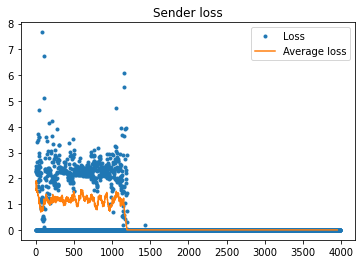

In [ ]:
plt.plot(sender_log, linestyle="None", marker=".", label="Loss")
plt.plot(np.convolve(sender_log, np.ones((40,))/40, mode='valid'), label="Average loss")
plt.legend()
plt.title("Sender loss");

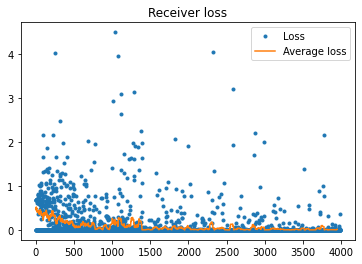

In [ ]:
plt.plot(receiver_log, linestyle="None", marker=".", label="Loss")
plt.plot(np.convolve(receiver_log, np.ones((40,))/40, mode='valid'), label="Average loss")
plt.legend()
plt.title("Receiver loss");